- Build a regression model to predict boston house prices.
## Data prepariation

In [12]:
from keras.datasets import boston_housing
(train_data, train_targets),(test_data, test_tragets) = boston_housing.load_data()
print("train_data sample num: ", len(train_data))
print("test_data sample num: ", len(test_data))
print("feature dim is ", len(test_data[0]))
print("train_data[0]\n", train_data[0])
print("train_label[0]\n", train_labels[0])

train_data sample num:  404
test_data sample num:  102
feature dim is  13
train_data[0]
 [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
train_label[0]
 15.2


### 数据标准化处理
- 对于不在同一个量级上的特征，需要进行标准化：将sample中13个维度的数据，分别计算均值和标准差；每个数据减去均值并除以标准差，就是经过标准化处理后的数据。使用这种数据进行学习，可以减少不同维度量级对学习的影响。

In [13]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Model build

In [16]:
from keras import models
from keras import layers
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # 回归输出只有一个节点
    model.compile(optimizer='rmsprop', 
                  loss='mse',  # 均方差 mean squared error
                  metrics=['mae'])  # 平均绝对误差 mean absolute error
    return model

### K folder validataion set and do validate

- 由于我们的训练集和测试集都比较小，因此需要用k-folder方法做validation的划分，避免太小的验证集导致的波动。具体地，将训练集划分为K份，实例化K个相同的模型，将每个模型在K-1个分区上训练，在最后一个分区上进行验证。模型的验证分数等于K个验证分数的平均值。

In [17]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_score = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                         train_targets[(i+1) * num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_score.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [23]:
print(all_score)
print("k折校验后结论是平均误差在",np.mean(all_score))

[2.1912293752821363, 2.2184306017243034, 2.8665915432542857, 2.3865235772463356]
k折校验后结论是平均误差在 2.4156937743767655


- 从数据上看，2.4的误差还是比较大的，修改epochs为500试试看

In [26]:
k = 4
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i+1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                         train_targets[(i+1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [29]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### Draw validation result

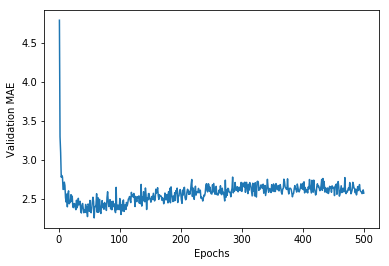

In [31]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

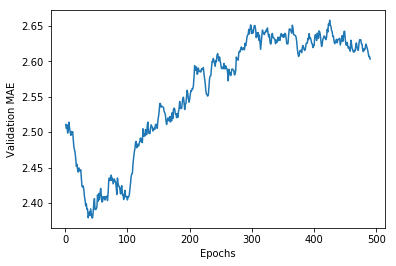

In [32]:
# do data smooth
def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + (1-factor)*point)
        else:
            smoothed_points.append(point)
    return smoothed_points
# 去掉前10个并平滑
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 从上图可见，validation mae在epochs=40的时候最低，之后就一路走高，进入过拟合

### 训练最终模型

In [34]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=40, batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_tragets)
print(test_mse_score, test_mae_score)

102/102 [==============================] - 0s 901us/step
19.011254703297336 2.7410807142070697
